
## Mixture Density Networks

This technique was proposed by Christopher M. Bishop in 1994. It is a type of PDF shaping regression technique using gaussian distributions only. 

The paper: https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf



In [1]:
##############################################################
## 
## Mixture Density Networks (MDN)
##
## 2022
## 
##############################################################

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader


###############################################################

N_EPOCHS = 1000    ## 500
batch_size = 5  ## 50
learning_rate = 1e-5     ## 0.0003
sigma_0 = 0.1
samples = 50
display_step = 50

###############################################################



## The Probability Density Function of the Normal Distribution

<br/>

<center>
    
$ \large p(x) = \frac{1}{\sqrt{2 \pi \sigma ^2}} e^{- \frac{(x - \mu)^2}{2 \sigma ^2}} $
    
</center>

<br/>

0.0008934243094088592
0.002360535108011208
[0.04682144 0.         0.04682144 0.09364287 0.23410718 0.28092862
 0.28092862 0.98325015 1.12371446 1.49828595 1.49828595 2.71564328
 2.85610759 3.74571487 3.69889343 3.83935774 3.97982205 2.90292902
 3.74571487 3.652072   2.57517897 2.52835754 2.01332174 0.79596441
 0.84278585 0.46821436 0.18728574 0.         0.09364287 0.09364287]
[-0.3428894  -0.32153166 -0.30017393 -0.27881619 -0.25745845 -0.23610071
 -0.21474297 -0.19338523 -0.17202749 -0.15066975 -0.12931202 -0.10795428
 -0.08659654 -0.0652388  -0.04388106 -0.02252332 -0.00116558  0.02019216
  0.0415499   0.06290763  0.08426537  0.10562311  0.12698085  0.14833859
  0.16969633  0.19105407  0.21241181  0.23376955  0.25512728  0.27648502
  0.29784276]
(31,)


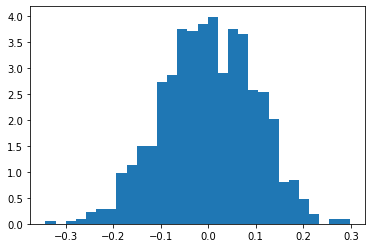

In [2]:


mu_rc    = 0         ## zero mean
sigma_rc = 0.1       ## standard deviation

s_rc = np.random.normal(mu_rc, sigma_rc, 1000)

## verify the mean and variance

print(  abs(mu_rc     -  np.mean(s_rc))  )
print(  abs(sigma_rc  -  np.std(s_rc, ddof=1)))


## Display the histogram of the samples, and the PDF function

count, bins, ignored = plt.hist(s_rc, 30, density=True)

print(count)
print(bins)
print(bins.shape)


In [3]:

def gaussian_pdf(x):
    return 1/(sigma_rc * np.sqrt(2 * np.pi)) * np.exp( - (x - mu_rc)**2 / (2 * sigma_rc**2))


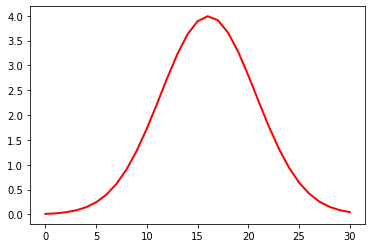

In [4]:

plt.plot(gaussian_pdf(bins), linewidth=2, color='r')


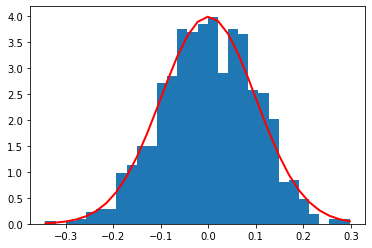

In [5]:

count, bins, ignored = plt.hist(s_rc, 30, density=True)
plt.plot(bins, gaussian_pdf(bins), linewidth=2, color='r')
plt.show()


## Functions for data with quadratic shape and Normally distributed error

In [6]:

###############################################################
## quadratic function

def f(x):
    return x**2-6*x+9 

###############################################################
## This function generates quadratic data perturbed with error
## which follows a normal distribution
## the sigma*x is what increases the standard deviation of the 
## error proportionally as x grows


def data_generator(x, sigma_0, samples):
    ##                      mean     standard dev      
    return np.random.normal(f(x),    sigma_0*x,     samples)

###############################################################


## Data x for quadratic curve

In [7]:

x_vals = np.arange(1, 5.2, 0.2)
print(x_vals)


[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5. ]


## Data points from g(x) for scatter

The g(x) function is made up of f(x) and the error. This process is done in the following for loop. 

$  \large g(x) = f(x) + \epsilon  $

In [8]:


x_arr = np.array([])
y_arr = np.array([])


for x in x_vals:
    ## for every sample in x_vals, generate n=50 normally distributed
    ## samples for y_arr
    x_arr = np.append(    x_arr,   np.full(samples, x)                       )
    y_arr = np.append(    y_arr,   data_generator(x, sigma_0, samples)       )

    
x_arr, y_arr   =   shuffle(x_arr, y_arr)

print(x_arr)
print(y_arr)
print(x_arr.shape)
print(y_arr.shape)



[1.8 2.8 2.2 ... 2.8 4.6 3.4]
[ 1.60266927 -0.25753327  0.38460742 ... -0.17801864  2.24212702
 -0.04009378]
(1050,)
(1050,)


## Plot the g(x) function



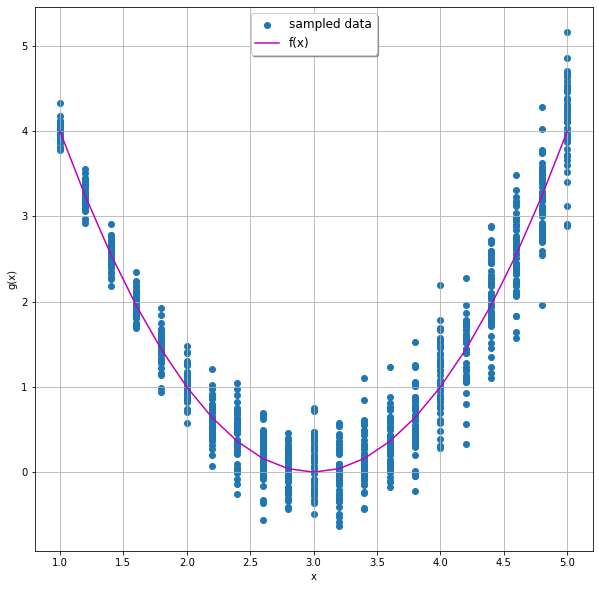

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')

ax.scatter(x_arr,y_arr,label='sampled data')

ax.plot( x_vals, list(map(f,x_vals)), c='m', label='f(x)')

ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Convert train data to pyTorch

In [10]:


inputs  = x_arr
targets = y_arr

## make into column vectors
inputs  = inputs.reshape((-1, 1))
targets = targets.reshape((-1, 1))

## fix data type
inputs  = inputs.astype(np.float32)
targets = targets.astype(np.float32)

## convert to torch tensors
inputs  = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

print(inputs)
print(targets)



tensor([[1.8000],
        [2.8000],
        [2.2000],
        ...,
        [2.8000],
        [4.6000],
        [3.4000]])
tensor([[ 1.6027],
        [-0.2575],
        [ 0.3846],
        ...,
        [-0.1780],
        [ 2.2421],
        [-0.0401]])


## Create Torch DataLoader

In [11]:
#####################################################################
## define dataset

train_ds = TensorDataset(inputs, targets)

print(  train_ds[0:3]  )
    
#####################################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

print(    next(iter(train_dl))   )


####################################################################

(tensor([[1.8000],
        [2.8000],
        [2.2000]]), tensor([[ 1.6027],
        [-0.2575],
        [ 0.3846]]))
[tensor([[4.4000],
        [2.2000],
        [4.2000],
        [1.4000],
        [5.0000]]), tensor([[2.4587],
        [0.3636],
        [1.3959],
        [2.7589],
        [3.9172]])]


## Fit a deep learning regression network to the g(x) data

In [12]:

#####################################################################

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(model(inputs), targets))
    

#####################################################################
## starts fitting after 1000 iterations
## use Tanh or sigmoid ?? 

class DL_Net(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()             ## nn.ReLU()
        self.linear2 = nn.Linear(12, 12)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(12, 1)
         
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        return x
    
#######################################################
## Does not fit using ReLU! Why ??

class SimpleNet(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()
        self.linear2 = nn.Linear(12, 1)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x
    
    
#############################################################

model   = DL_Net()    ## 5000 epochs to get a better fit
## model   = SimpleNet()
## opt     = torch.optim.SGD(   model.parameters(), lr=learning_rate   )
opt        = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

#############################################################

fit(N_EPOCHS, model, loss_fn, opt)

preds = model(inputs)

print(preds)
print(targets)

#############################################################



Training loss: tensor(0.1864, grad_fn=<MseLossBackward0>)
tensor([[ 1.4366],
        [-0.0691],
        [ 0.4099],
        ...,
        [-0.0691],
        [ 2.4845],
        [ 0.4317]], grad_fn=<AddmmBackward0>)
tensor([[ 1.6027],
        [-0.2575],
        [ 0.3846],
        ...,
        [-0.1780],
        [ 2.2421],
        [-0.0401]])


## Generate Test x data, and use model to predict

In [13]:

x_test_orig         =   np.arange( 1.1, 5.1, 0.2)
print(x_test_orig)

x_test = x_test_orig

x_test  = x_test.reshape((-1, 1))
x_test  = x_test.astype(np.float32)
x_test  = torch.from_numpy(x_test)

print(x_test)



[1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9 4.1 4.3 4.5
 4.7 4.9]
tensor([[1.1000],
        [1.3000],
        [1.5000],
        [1.7000],
        [1.9000],
        [2.1000],
        [2.3000],
        [2.5000],
        [2.7000],
        [2.9000],
        [3.1000],
        [3.3000],
        [3.5000],
        [3.7000],
        [3.9000],
        [4.1000],
        [4.3000],
        [4.5000],
        [4.7000],
        [4.9000]])


## Use model to predict on test data

In [14]:

y_pred  = model(x_test)

print(y_pred)
print(targets)



tensor([[ 3.6949],
        [ 3.1059],
        [ 2.4414],
        [ 1.7610],
        [ 1.1336],
        [ 0.6162],
        [ 0.2410],
        [ 0.0151],
        [-0.0720],
        [-0.0389],
        [ 0.0931],
        [ 0.3033],
        [ 0.5728],
        [ 0.8852],
        [ 1.2261],
        [ 1.5834],
        [ 1.9465],
        [ 2.3072],
        [ 2.6587],
        [ 2.9960]], grad_fn=<AddmmBackward0>)
tensor([[ 1.6027],
        [-0.2575],
        [ 0.3846],
        ...,
        [-0.1780],
        [ 2.2421],
        [-0.0401]])


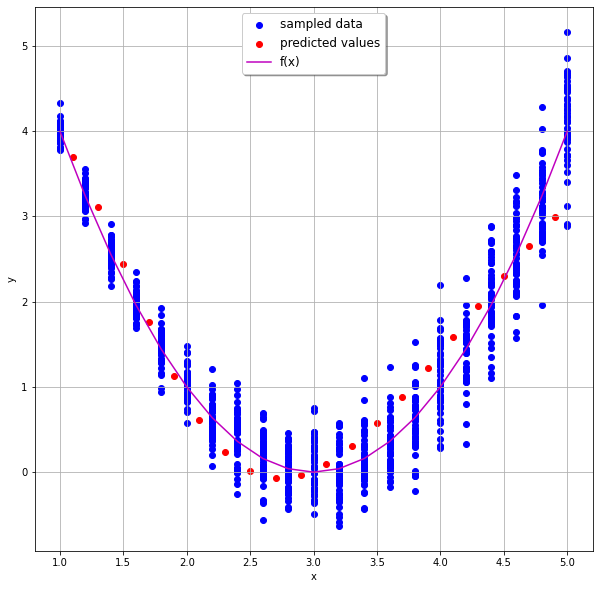

In [15]:


fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

ax.scatter(x_arr,y_arr,c='b',label='sampled data')

ax.scatter(x_test.detach().numpy() ,y_pred.detach().numpy() ,c='r',label='predicted values')

ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')

ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()



From the red dots, it seems our Neural Net only learned the f(x) part of g(x) and it completely ignored the $ \epsilon $ error normally distributed random variable. To address this issue Christopher Bishop proposed MDNs. 

## Now repeat with an MDN

In [16]:
###############################################################################

'''

##################################################################


def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))

##################################################################


InputLayer = Input(shape=(1,))
Layer_1 = Dense(12,activation="tanh")(InputLayer)
Layer_2 = Dense(12,activation="tanh")(Layer_1)
mu = Dense(1, activation="linear")(Layer_2)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([x_arr, y_arr], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
                          
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))

mu_pred, sigma_pred = model.predict(list((x_test,x_test))) 
# the model expects a list of arrays as it has 2 inputs


fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',
                                    ms=10,label='predicted distributions')
                                    
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',
                                lw=2,ls='None',marker='.',ms=10,label='true distributions')
                                
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

'''



'\n\n##################################################################\n\n\ndef mdn_cost(mu, sigma, y):\n    dist = tfp.distributions.Normal(loc=mu, scale=sigma)\n    return tf.reduce_mean(-dist.log_prob(y))\n\n##################################################################\n\n\nInputLayer = Input(shape=(1,))\nLayer_1 = Dense(12,activation="tanh")(InputLayer)\nLayer_2 = Dense(12,activation="tanh")(Layer_1)\nmu = Dense(1, activation="linear")(Layer_2)\nsigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)\ny_real = Input(shape=(1,))\nlossF = mdn_cost(mu,sigma,y_real)\nmodel = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])\nmodel.add_loss(lossF)\nadamOptimizer = optimizers.Adam(learning_rate=learning_rate)\nmodel.compile(optimizer=adamOptimizer,metrics=[\'mse\'])\nhistory_cache = model.fit([x_arr, y_arr], #notice we are using an input to pass the real values due to the inner workings of keras\n                          verbose=0, # write =1 if you wish to see the 